# Lab 2: Convolutional Neural Network 
This notebook has been prepared by Hsiu-Wen (Kelly) Chang from MINES ParisTech for the class of HPC-AI 2022


## Goal
In this lab, we will continue the same task in Lab 1 but with CNN artecture to improve the performance

### Previous in lab 1

In [1]:
%matplotlib inline
import torch
import torchvision
import sys
print('Your python version: {}'.format(sys.version_info.major))

Your python version: 3


In [2]:
# Hyperparameters
batch_size_train = 64 # batch size
batch_size_test = 1000
lr = 0.01 # learning rate
epochs = 10 # training epochs

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

PermissionError: [Errno 13] Permission denied: '/files'

In [28]:
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader


x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print('Number of sample: {} \nSize of input:{}'.format(n,c))

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

Number of sample: 50000 
Size of input:784


<ipython-input-28-1e5eebcb9929>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


torch.Size([50000, 784])
ground_truth:5


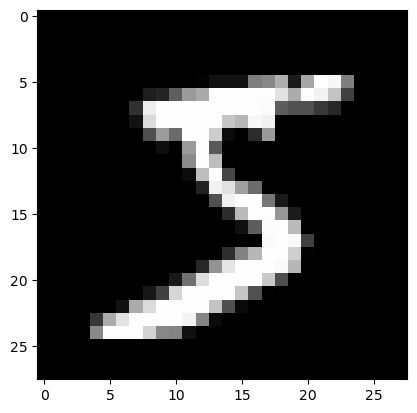

In [23]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)
print(f"ground_truth:{y_train[0]}")

In [24]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [25]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call ``model.train()`` before training, and ``model.eval()``
before inference, because these are used by layers such as ``nn.BatchNorm2d``
and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)



In [30]:
class Mnist_logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10)
    
    def forward(self, xb):
        return self.lin(xb)
    
def get_model():
    model = Mnist_logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

loss_func = F.cross_entropy

In [31]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.6298)
1 tensor(0.4873)
2 tensor(0.4315)
3 tensor(0.4002)
4 tensor(0.3806)
5 tensor(0.3657)
6 tensor(0.3550)
7 tensor(0.3464)
8 tensor(0.3398)
9 tensor(0.3338)


## Final three lines code

Create fit() and get_data()

(1) Define a function ``loss_batch`` which computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform
backprop.  For the validation set, we don't pass an optimizer, so the
method doesn't perform backprop.



In [32]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

(2) ``fit`` runs the necessary operations to train our model and compute the training and validation losses for each epoch.



In [33]:
import numpy as np
# meaning of * is to unpacks a list or tuple into position arguments

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train() #set the mode to training mode. if we use model.train(false), it will become evaluation mode
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

(3) ``get_data`` returns dataloaders for the training and validation sets.



In [34]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now, our whole process of obtaining the data loaders and fitting the
model can be run in 3 lines of code:



In [35]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.6317909804344177
1 0.48972965540885927
2 0.43378640098571775
3 0.40269780976772307
4 0.38283069169521333
5 0.36854054698944094
6 0.3575570048093796
7 0.34911181468963626
8 0.342390913271904
9 0.3364930906534195


# Assignment 2: plot loss values and validations values
In order to understand the progress of your training, error curves with test and validation are very common to be shown.
Change your code in order to see the curves

You can use these basic 3 lines of code to train a wide variety of models.
Let's see if we can use them to train a convolutional neural network (CNN)!

Switch to CNN
-------------

We are now going to build our neural network with three convolutional layers.
Because none of the functions in the previous section assume anything about
the model form, we'll be able to use them to train a CNN without any modification.

We will use Pytorch's predefined
`Conv2d <https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d>`_ class
as our convolutional layer. We define a CNN with 3 convolutional layers.
Each convolution is followed by a ReLU.  At the end, we perform an
average pooling.  (Note that ``view`` is PyTorch's version of numpy's
``reshape``)



In [36]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

`Momentum <https://cs231n.github.io/neural-networks-3/#sgd>`_ is a variation on
stochastic gradient descent that takes previous updates into account as well
and generally leads to faster training.



In [37]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.382933112180233
1 0.2702909678697586
2 0.20762188514471053
3 0.18016452248990536
4 0.1900676942527294
5 0.1664056705713272
6 0.14920399511754512
7 0.17533807607293128
8 0.13726386784613132
9 0.13912812107503414


nn.Sequential
------------------------

``torch.nn`` has another handy class we can use to simply our code:
`Sequential <https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential>`_ .
A ``Sequential`` object runs each of the modules contained within it, in a
sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a
**custom layer** from a given function.  For instance, PyTorch doesn't
have a `view` layer, and we need to create one for our network. ``Lambda``
will create a layer that we can then use when defining a network with
``Sequential``.



In [39]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

The model created with ``Sequential`` is simply:



In [40]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.36149111242294313
1 0.2670303117990494
2 0.22516312140226363
3 0.2877102443575859
4 0.17123320768177508
5 0.16590370565652848
6 0.1554075716018677
7 0.14590528378486634
8 0.1460394793987274
9 0.13605394797325135


Wrapping DataLoader
-----------------------------

Our CNN is fairly concise, but it only works with MNIST, because:
 - It assumes the input is a 28\*28 long vector
 - It assumes that the final CNN grid size is 4\*4 (since that's the average
pooling kernel size we used)

Let's get rid of these two assumptions, so our model works with any 2d
single channel image. First, we can remove the initial Lambda layer but
moving the data preprocessing into a generator:



In [44]:
#Kelly: I am not so sure why this one can deal with any size of 2d image...

def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace ``nn.AvgPool2d`` with ``nn.AdaptiveAvgPool2d``, which
allows us to define the size of the *output* tensor we want, rather than
the *input* tensor we have. As a result, our model will work with any
size input.



In [59]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Let's try it out:



In [60]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33848215029239653
1 0.3312550708770752


Using your GPU
---------------

If you're lucky enough to have access to a CUDA-capable GPU (you can
rent one for about $0.50/hour from most cloud providers) you can
use it to speed up your code. First check that your GPU is working in
Pytorch:



In [41]:
print(torch.cuda.is_available())

True


And then create a device object for it:



In [42]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Let's update ``preprocess`` to move batches to the GPU:



In [46]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Finally, we can move our model to the GPU.



In [47]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

You should find it runs faster now:



In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Closing thoughts
-----------------

We now have a general data pipeline and training loop which you can use for
training many types of models using Pytorch. To see how simple training a model
can now be, take a look at the `mnist_sample` sample notebook.

Of course, there are many things you'll want to add, such as data augmentation,
hyperparameter tuning, monitoring training, transfer learning, and so forth.
These features are available in the fastai library, which has been developed
using the same design approach shown in this tutorial, providing a natural
next step for practitioners looking to take their models further.

We promised at the start of this tutorial we'd explain through example each of
``torch.nn``, ``torch.optim``, ``Dataset``, and ``DataLoader``. So let's summarize
what we've seen:

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module(usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.

